In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from torch.optim.optimizer import Optimizer,required
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
import math

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
train_indices= np.random.randint(low=0, high=50000, size=1000)
train_indices= list(train_indices)


test_indices= np.random.randint(low=0, high=10000, size=200)
test_indices= list(test_indices)

In [5]:
len(train_indices)

1000

In [6]:
len(testset)

10000

In [7]:
sampler=SubsetRandomSampler(train_indices)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False, sampler= sampler)

sampler=SubsetRandomSampler(test_indices)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, sampler=sampler)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
model= models.resnet18(pretrained=True)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
## AdamW:
# class AdamW_method(Optimizer):

#     def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,weight_decay=0, amsgrad=False):
        
#         defaults = dict(lr=lr, betas=betas, eps=eps,
#                         weight_decay=weight_decay, amsgrad=amsgrad)
#         super(AdamW_method, self).__init__(params, defaults)

#     def __setstate__(self, state):
#         super(AdamW_method, self).__setstate__(state)
        
#         for group in self.param_groups:
#             group.setdefault('amsgrad', False)

#     def step(self, closure=None):
#         """Performs a single optimization step.
#         Arguments:
#             closure (callable, optional): A closure that reevaluates the model
#                 and returns the loss.
#         """
#         loss = None
#         if closure is not None:
#             loss = closure()

#         for group in self.param_groups:
#             for p in group['params']:
#                 if p.grad is None:
#                     continue
#                 grad = p.grad.data
#                 if grad.is_sparse:
#                     raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
#                 amsgrad = group['amsgrad']

#                 state = self.state[p]

#                 # State initialization
#                 if len(state) == 0:
#                     state['step'] = 0
#                     # Exponential moving average of gradient values
#                     state['exp_avg'] = torch.zeros_like(p.data)
#                     # Exponential moving average of squared gradient values
#                     state['exp_avg_sq'] = torch.zeros_like(p.data)
#                     if amsgrad:
#                         # Maintains max of all exp. moving avg. of sq. grad. values
#                         state['max_exp_avg_sq'] = torch.zeros_like(p.data)

#                 exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
#                 if amsgrad:
#                     max_exp_avg_sq = state['max_exp_avg_sq']
#                 beta1, beta2 = group['betas']

#                 state['step'] += 1

#                 # if group['weight_decay'] != 0:
#                 #     grad = grad.add(group['weight_decay'], p.data)

#                 # Decay the first and second moment running average coefficient
#                 exp_avg.mul_(beta1).add_(1 - beta1, grad)
#                 exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
#                 if amsgrad:
#                     # Maintains the maximum of all 2nd moment running avg. till now
#                     torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
#                     # Use the max. for normalizing running avg. of gradient
#                     denom = max_exp_avg_sq.sqrt().add_(group['eps'])
#                 else:
#                     denom = exp_avg_sq.sqrt().add_(group['eps'])

#                 bias_correction1 = 1 - beta1 ** state['step']
#                 bias_correction2 = 1 - beta2 ** state['step']
#                 step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

#                 # p.data.addcdiv_(-step_size, exp_avg, denom)
#                 p.data.add_(-step_size,  torch.mul(p.data, group['weight_decay']).addcdiv_(1, exp_avg, denom) )

#         return loss


class AdamW_method(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        # if not 0.0 <= lr:
        #     raise ValueError("Invalid learning rate: {}".format(lr))
        # if not 0.0 <= eps:
        #     raise ValueError("Invalid epsilon value: {}".format(eps))
        # if not 0.0 <= betas[0] < 1.0:
        #     raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        # if not 0.0 <= betas[1] < 1.0:
        #     raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(AdamW_method, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW_method, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # if group['weight_decay'] != 0:
                #     grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # p.data.addcdiv_(-step_size, exp_avg, denom)
                p.data.add_(-step_size,  torch.mul(p.data, group['weight_decay']).addcdiv_(1, exp_avg, denom) )

        return loss


class SGDW(Optimizer):

    def __init__(self, params, lr=required, betas=(0.9, 0.999), momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov, betas=(0.9, 0.999))
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(SGDW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGDW, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
    
    
    @torch.no_grad()
    def step(self, closure=None):

      loss = None
      if closure is not None:
          with torch.enable_grad():
              loss = closure()

      for group in self.param_groups:
          params_with_grad = []
          d_p_list = []
          momentum_buffer_list = []
          weight_decay = group['weight_decay']
          momentum = group['momentum']
          dampening = group['dampening']
          nesterov = group['nesterov']
          lr = group['lr']
          beta1, beta2= group["betas"]

          for p in group['params']:
              
              if p.grad is  None:
                  continue
                  
              params_with_grad.append(p)
              d_p_list.append(p.grad)
              grad = p.grad.data

              state = self.state[p]
              
              if len(state) == 0:
                  state['step'] = 0
                  state['exp_avg'] = torch.zeros_like(p.data)
                  
              state['exp_avg'] = torch.zeros_like(p.data)
              
              exp_avg = state['exp_avg']
              
              if 'momentum_buffer' not in state:
                  momentum_buffer_list.append(None)
              else:
                  momentum_buffer_list.append(state['momentum_buffer'])
                  
              state['step'] += 1
              
                #buf = state['momentum_buffer'] # Estimated gradient
              
              exp_avg.mul_(beta1).add_(1 - beta1, grad)
              p.data.add_(-torch.mul(p.data, group['weight_decay'])).add_(-exp_avg)

      return loss

In [33]:
def optimizers(model, opti_name, lr, weight_decay):
    if opti_name == 'SGD':
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    
    elif opti_name == 'Adam':
        return optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay)
    
    elif opti_name == 'AdamW':
        return AdamW_method(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay)
    
    elif opti_name == 'SGDW':
        return SGDW(model.parameters(), lr=lr, betas=(0.9, 0.999), momentum=0, dampening=0,
                 weight_decay=0, nesterov=False)
    else:
      print('Error')

In [34]:
def train(model, optimizer, epoch):
    print('Epoch: %d' % (epoch+1))
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * targets.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print("Training Loss: ", train_loss/total)
    print("Training error:", 1-correct/total)
    return 1 - correct/total, train_loss/total

def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    print("Test error:", 1-correct/total)
    return 1 - correct/total

In [35]:
criterion = nn.CrossEntropyLoss()

In [36]:
def save_err(train_loss, train_err, test_err, model, learning_rate, batch_size, weight_decay, epochs, N):
    csvname = model + '_LR'+str(learning_rate) + '_B'+str(batch_size) + '_N'+ str(N) + '_E' + str(epochs)
    csvname = 'Curves_' + csvname

    current_name = csvname +'.csv'
    files_present = glob.glob(current_name)
    if files_present:
        print('WARNING: This file already exists!')
    data_dict = {}
    for mode in test_err:
        data_dict[mode+'_test_err'] = test_err[mode]
        data_dict[mode+'_training_err'] = train_err[mode]
        data_dict[mode+'_training_loss'] = train_loss[mode]
    df = pd.DataFrame(data=data_dict)
    if not files_present:
        df.to_csv(current_name, sep=',', header=True, index=False)
    else:
        print('WARNING: This file already exists!')
        for i in range(1,30):
            files_present = glob.glob(csvname+'_'+str(i)+'.csv')
            if not files_present:
                df.to_csv(csvname+'_'+str(i)+'.csv', sep=',', header=True, index=False)
                return None
    return None

In [37]:
def optimizer_peformance(model, learning_rate, batch_size, weight_decay, epochs, N, mode):
    net = model
    net = net.to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = True
        
    train_err = []
    train_loss = []
    test_err = []
    
    opti_name = mode
    optimizer = optimizers(net, opti_name, learning_rate, weight_decay)
    
    lambda_lr = lambda epoch: 0.1 ** (epoch // 80) 
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr)
    
    start_time = time.time()
    print("-"*30+" Mode "+ mode+" starts" )
    for epoch in range(epochs):
        train_err_i, train_loss_i = train(net, optimizer, epoch)
        train_err.append(train_err_i)
        train_loss.append(train_loss_i)
        test_err.append(test(net))
        scheduler.step()
        print ("--- %s seconds ---" % (time.time() - start_time))
        
    save_err({mode:train_loss}, {mode:train_err}, {mode:test_err}, 'Resnet'+'_'+mode, learning_rate, batch_size, weight_decay, epochs, N)
    return train_loss, train_err, test_err

In [38]:
def optimizer_performance_comparison(model, batch_size, weight_decay, epochs, N):
    train_loss, train_err, test_err = {}, {}, {}
    mode_list = ['SGD', 'Adam', 'AdamW']
    lr_dict = [0.001, 0.001, 0.001]
    # mode_list = ['SGDW', 'SGD', 'Adam', 'AdamW'] 
    # lr_dict = [0.001, 0.001, 0.001, 0.001]
    for i,mode in enumerate(mode_list):
        train_loss[mode], train_err[mode], test_err[mode] = optimizer_peformance(model, lr_dict[i], batch_size, weight_decay, epochs, N, mode.split(None, 1)[0])
    return train_loss, train_err, test_err

In [39]:
def plot_figure(model, train_loss, train_err, test_err, batch_size, weight_decay, epochs, N): 
    # model= 'Resnet'
    figure_name = 'Resnet' + '_B'+str(batch_size) + '_N'+ str(N) + '_E' + str(epochs)
    
    plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'


    fig = plt.figure()

    axes = plt.gca()
    for key in test_err:
        break
    # axes.set_ylim([0., 0.2])
    axes.set_xlim([0,epochs])
    # mode_list = ['SGD', 'Adam', 'AdamW', 'SGDW'] 
    mode_list = ['SGD', 'Adam', 'AdamW']
    colors = ['red','blue','green','orange','pink','cyan','brown','yellow','black']
    for idx,mode in enumerate(mode_list):
        plt.plot(np.arange(1,epochs+1), test_err[mode], label=mode, ls='solid', linewidth=2, color=colors[idx])
        
    plt.title(figure_name)
    plt.ylabel('Test Error')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()
    plt.show()
    
    fig.savefig('Test_errors_'+figure_name + '.png')
    fig.savefig('Test_errors_'+figure_name+'.pdf', format='pdf', bbox_inches = 'tight')
    
    fig = plt.figure()
    axes = plt.gca()
    axes.set_yscale('log')
    axes.set_ylim([1e-4, 1.])
    axes.set_xlim([0,epochs])
    for idx,mode in enumerate(mode_list):
        plt.plot(np.arange(1,epochs+1), train_loss[mode], label=mode, ls='solid', linewidth=2, color=colors[idx])

    plt.title(figure_name)
    plt.ylabel('Training Loss')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()
    plt.show()
    
    fig.savefig('Training_loss_'+figure_name + '.png')
    fig.savefig('Training_loss_'+figure_name+'.pdf', format='pdf', bbox_inches = 'tight')

In [40]:
## Experiments

batch_size = 64
weight_decay = 1e-4
epochs = 150

# Training data size
N = 1000

In [41]:
train_loss, train_err, test_err = optimizer_performance_comparison(model, batch_size, weight_decay, epochs, N)

------------------------------ Mode SGD starts
Epoch: 1
Training Loss:  0.00017411256558261812
Training error: 0.0
Test error: 0.49
--- 1.5392587184906006 seconds ---
Epoch: 2
Training Loss:  0.00015281672030687332
Training error: 0.0
Test error: 0.48
--- 2.978391647338867 seconds ---
Epoch: 3
Training Loss:  0.00011742905899882316
Training error: 0.0
Test error: 0.49
--- 4.395299911499023 seconds ---
Epoch: 4
Training Loss:  0.00019676113943569362
Training error: 0.0
Test error: 0.485
--- 5.824785470962524 seconds ---
Epoch: 5
Training Loss:  0.00018066987069323659
Training error: 0.0
Test error: 0.49
--- 7.24848198890686 seconds ---
Epoch: 6
Training Loss:  0.00019711378286592663
Training error: 0.0
Test error: 0.48
--- 8.68278956413269 seconds ---
Epoch: 7
Training Loss:  0.000278948238468729
Training error: 0.0
Test error: 0.485
--- 10.101934909820557 seconds ---
Epoch: 8
Training Loss:  0.00017275475303176792
Training error: 0.0
Test error: 0.49
--- 11.530040264129639 seconds ---


In [42]:
import pandas as pd
df1= pd.DataFrame(train_err)

df2= pd.DataFrame(test_err)

df3= pd.DataFrame(train_loss)

df1.to_csv('train_err.csv', index= False)
df2.to_csv('test_err.csv', index= False)
df3.to_csv('train_loss.csv', index= False)

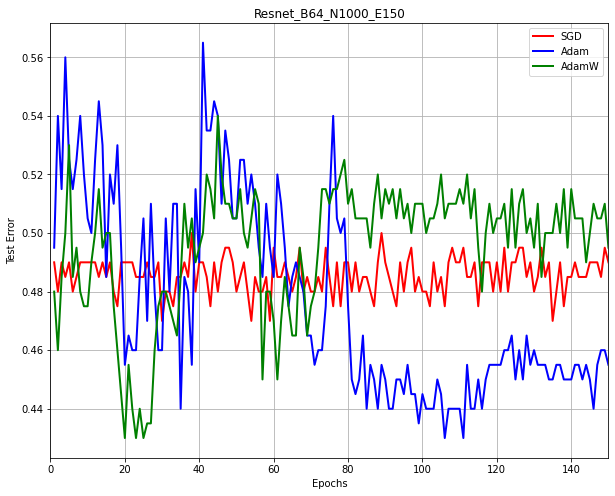

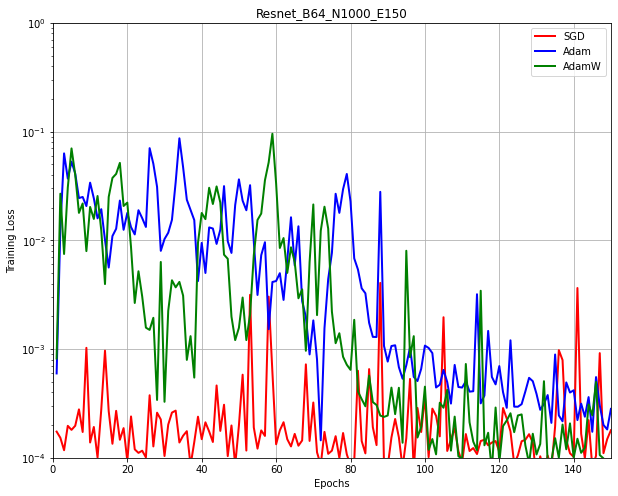

In [43]:
plot_figure(model, train_loss, train_err, test_err, batch_size, weight_decay, epochs, N)

## Experimentation 2

In [54]:
WD= np.linspace(1e-7,1e-3,12)
# All_train_loss=[]
num_epochs=150
batch_size = 64
# weight_decay = 1e-4
# epochs = 150

# # Training data size
# N = 1000

In [55]:
train_err = []
train_loss = []
test_err = []

In [56]:
train_err_adam = []
train_loss_adam = []
test_err_adam = []

In [57]:
# optim_W= AdamW_method(model.parameters(), lr=0.001, betas=(0.9, 0.99), weight_decay = i)
# optimizer= optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [58]:
for i in WD:

  optim_W= optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99), weight_decay = i)
  # optim_W= AdamW_method(model.parameters(), lr=0.001, betas=(0.9, 0.99), weight_decay = i)
  exp_lr_scheduler = lr_scheduler.StepLR(optim_W, step_size=7, gamma=0.1)

  print('-----For Weight decay {}-----'.format(i))
  train_err_i, train_loss_i= train(model, optim_W, num_epochs)

  train_err_adam.append(train_err_i)
  train_loss_adam.append(train_loss_i)
  test_err_adam.append(test(model)) 


  # train_err.append(train_err_i)
  # train_loss.append(train_loss_i)

  # test_err.append(test(model))


  # All_train_loss.append(train_loss)

-----For Weight decay 1e-07-----
Epoch: 151
Training Loss:  0.012301221197005361
Training error: 0.0030000000000000027
Test error: 0.43000000000000005
-----For Weight decay 9.1e-05-----
Epoch: 151
Training Loss:  0.023258586882613598
Training error: 0.007000000000000006
Test error: 0.42500000000000004
-----For Weight decay 0.0001819-----
Epoch: 151
Training Loss:  0.07675942343473434
Training error: 0.017000000000000015
Test error: 0.41500000000000004
-----For Weight decay 0.0002728-----
Epoch: 151
Training Loss:  0.015681183964712544
Training error: 0.0040000000000000036
Test error: 0.39
-----For Weight decay 0.0003637-----
Epoch: 151
Training Loss:  0.04912624191772193
Training error: 0.01200000000000001
Test error: 0.4
-----For Weight decay 0.0004546-----
Epoch: 151
Training Loss:  0.024023228554055094
Training error: 0.006000000000000005
Test error: 0.45499999999999996
-----For Weight decay 0.0005455-----
Epoch: 151
Training Loss:  0.032518476124852896
Training error: 0.00700000000

In [78]:
len(train_err_adam)

12

In [47]:
len(train_loss)

24

In [48]:
test_err

[0.505,
 0.52,
 0.515,
 0.54,
 0.45999999999999996,
 0.495,
 0.44499999999999995,
 0.475,
 0.44499999999999995,
 0.475,
 0.46499999999999997,
 0.46499999999999997]

In [ ]:
N= 1000

In [55]:
test_err

[0.505,
 0.52,
 0.515,
 0.54,
 0.45999999999999996,
 0.495,
 0.44499999999999995,
 0.475,
 0.44499999999999995,
 0.475,
 0.46499999999999997,
 0.46499999999999997]

In [90]:
len(test_err)

12

In [91]:
WD

array([1.000e-07, 9.100e-05, 1.819e-04, 2.728e-04, 3.637e-04, 4.546e-04,
       5.455e-04, 6.364e-04, 7.273e-04, 8.182e-04, 9.091e-04, 1.000e-03])

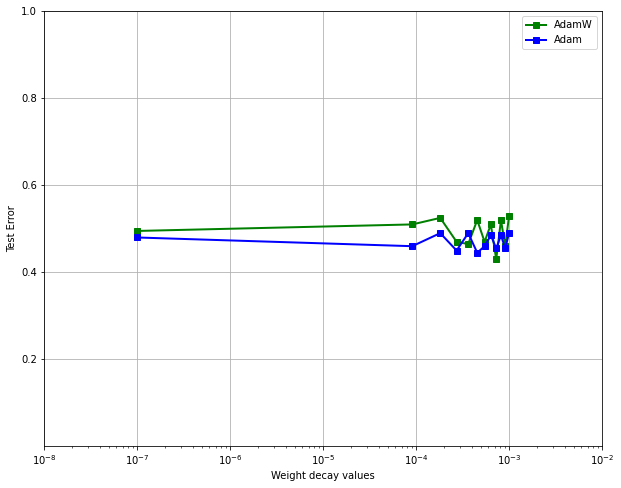

In [129]:
# figure_name = 'Resnet' + '_B'+str(batch_size) + '_N'+ str(N) + '_E' + str(epochs)
    
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


fig = plt.figure()
axes = plt.gca()
# axes.set_yscale('log')
axes.set_xscale('log')
axes.set_ylim([1e-3, 1.])
axes.set_xlim([1e-8, 1e-2])
plt.plot(WD, test_err, label='AdamW', ls='solid', linewidth=2, marker='s', color= 'green')
plt.plot(WD, test_err_adam, label='Adam', ls='solid', linewidth=2, marker='s', color= 'b')  
# plt.title(figure_name)
plt.ylabel('Test Error')
plt.xlabel('Weight decay values')
plt.grid()
plt.legend()
plt.show()

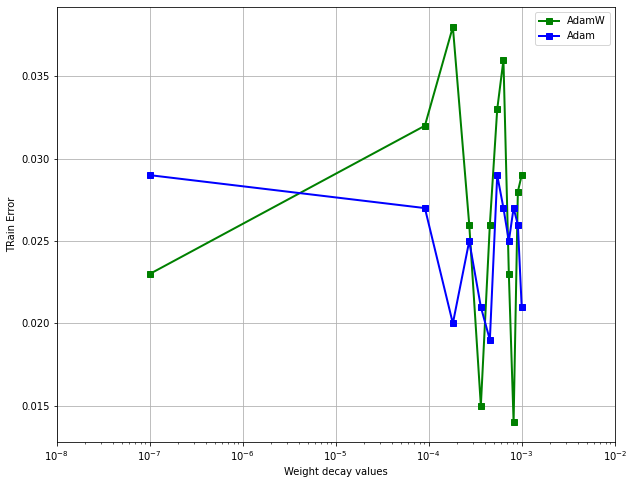

In [132]:
# figure_name = 'Resnet' + '_B'+str(batch_size) + '_N'+ str(N) + '_E' + str(epochs)
    
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


fig = plt.figure()
axes = plt.gca()
# axes.set_yscale('log')
axes.set_xscale('log')
# axes.set_ylim([1e-3, 1.])
axes.set_xlim([1e-8, 1e-2])
plt.plot(WD, train_err, label='AdamW', ls='solid', linewidth=2, marker='s', color= 'green')
plt.plot(WD, train_err_adam, label='Adam', ls='solid', linewidth=2, marker='s', color= 'b')  
# plt.title(figure_name)
plt.ylabel('TRain Error')
plt.xlabel('Weight decay values')
plt.grid()
plt.legend()
plt.show()

In [119]:
max(test_err_adam), min(test_err_adam)

(0.49, 0.44499999999999995)

In [120]:
max(test_err), min(test_err)

(0.53, 0.43000000000000005)

In [ ]:
Result={'WD_'+str(i):None for i in range(12)}

In [ ]:
Result

{'WD_0': None,
 'WD_1': None,
 'WD_2': None,
 'WD_3': None,
 'WD_4': None,
 'WD_5': None,
 'WD_6': None,
 'WD_7': None,
 'WD_8': None,
 'WD_9': None,
 'WD_10': None,
 'WD_11': None}

In [ ]:
liste=[i for i in range(12)]
res= [[t,m] for t,m in enumerate(liste)]

In [ ]:
res

[[0, 0],
 [1, 1],
 [2, 2],
 [3, 3],
 [4, 4],
 [5, 5],
 [6, 6],
 [7, 7],
 [8, 8],
 [9, 9],
 [10, 10],
 [11, 11]]

In [ ]:
for i,key in enumerate(Result):
    Result[key]= res[i]

In [ ]:
Result

{'WD_0': [0, 0],
 'WD_1': [1, 1],
 'WD_2': [2, 2],
 'WD_3': [3, 3],
 'WD_4': [4, 4],
 'WD_5': [5, 5],
 'WD_6': [6, 6],
 'WD_7': [7, 7],
 'WD_8': [8, 8],
 'WD_9': [9, 9],
 'WD_10': [10, 10],
 'WD_11': [11, 11]}

In [ ]:
import pandas as pd

In [ ]:
dt=pd.DataFrame(Result)
dt

,WD_0,WD_1,WD_2,WD_3,WD_4,WD_5,WD_6,WD_7,WD_8,WD_9,WD_10,WD_11
0,0,1,2,3,4,5,6,7,8,9,10,11
1,0,1,2,3,4,5,6,7,8,9,10,11


In [ ]:
dt= dt.T

In [ ]:
dt.to_csv('data.csv', index= False)

In [ ]:
dt

,0,1
WD_0,0,0
WD_1,1,1
WD_2,2,2
WD_3,3,3
WD_4,4,4
WD_5,5,5
WD_6,6,6
WD_7,7,7
WD_8,8,8
WD_9,9,9


In [ ]:
list(dt.iloc[0])

[0, 0]

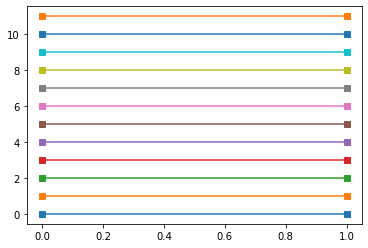

In [ ]:
for i in range(len(dt)):
    plt.plot(list(dt.iloc[i]), marker='s')